In [1]:
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt

In [3]:
_4dm3_data_fp = 'dataset/4dm3.db'
_4dm4_data_fp = 'dataset/4dm4.db'

_4dm4_data = sqlite3.connect(_4dm4_data_fp)
_4dm3_data = sqlite3.connect(_4dm3_data_fp)

In [4]:
_4dm4_sql = """SELECT * FROM scores WHERE beatmap_type != \"SV\""""
_4dm3_sql = """SELECT * FROM scores WHERE beatmap_type != \"SV\""""

_4dm4_dataset = pd.read_sql(_4dm4_sql, _4dm4_data)
_4dm3_dataset = pd.read_sql(_4dm3_sql, _4dm3_data)

In [5]:
_4dm4_dataset

,player_name,round,beatmap_type,beatmap_tag,score,score_logit
0,drag_,Q,RC,1,980590,3.922366
1,JPBenedictGame,Q,RC,1,991778,4.792686
2,iVALORUS,Q,RC,1,950399,2.952871
3,BL5,Q,RC,1,994054,5.119073
4,-Tebo-,Q,RC,1,994631,5.221730
...,...,...,...,...,...,...
2760,MisteurFR,GF,TB,1,932066,2.618867
2761,Gray Hardrock,GF,TB,1,908730,2.298226
2762,--Pavin--,GF,TB,1,919303,2.432914
2763,shokoha,GF,TB,1,910134,2.315272


In [6]:
_4dm3_dataset

,player_name,round,beatmap_type,beatmap_tag,score,score_logit
0,- Abby -,GS,HB,1,988547,4.457984
1,- Abby -,GS,LN,1,976270,3.716999
2,- Abby -,GS,RC,1,994089,5.125012
3,- Abby -,GS,RC,2,988411,4.446042
4,- Abby -,GS,RC,4,973958,3.621658
...,...,...,...,...,...,...
2126,zipp,GS,RC,4,977953,3.792285
2127,zipp,Q,HB,1,979542,3.868711
2128,zipp,Q,LN,1,942415,2.795184
2129,zipp,Q,RC,1,996276,5.589226


In [7]:
_4dm3_players = _4dm3_dataset['player_name']
_4dm4_players = _4dm4_dataset['player_name']
training_players = np.intersect1d(_4dm3_players, _4dm4_players)

In [8]:
@np.vectorize
def is_training(x):
    return x in training_players

training_4dm4 = _4dm4_dataset[is_training(_4dm4_players)]
training_4dm3 = _4dm3_dataset[is_training(_4dm3_players)]

In [9]:
from utils.etimodel import GeneralizedETIModel

model = GeneralizedETIModel(_4dm4_dataset, ['RC', 'HB', 'LN'])

In [10]:
model.fit_regression(_4dm3_dataset)

In [11]:
_4dm3_result = model.predict(_4dm3_dataset)

In [12]:
_4dm3_result.sort_values(0, ascending=False).head(15)

,0
[-Leon-],11.040662
2fast4you98,7.321128
shokoha,7.019722
Lenn,6.716820
Gerwin13,6.366370
Expired112,6.073163
Eon Musk,6.016847
palmEuEi,6.000706
Scep,5.244353
Yuragi,4.948597


In [13]:
from utils.etimodel import ETIModel
from utils.tables import get_table_from_records

eti_4dm4 = ETIModel()

def get_beatmap_category_table(records: pd.DataFrame, category: str):
    return get_table_from_records(records[records['beatmap_type'] == category], 'player_name', 'beatmap', 'score_logit')

_4dm4_dataset['beatmap'] = _4dm4_dataset['round'] + "_" + _4dm4_dataset['beatmap_type'] + "_" + _4dm4_dataset['beatmap_tag'].astype(str)
rc = get_beatmap_category_table(_4dm4_dataset, "RC")
hb = get_beatmap_category_table(_4dm4_dataset, "HB")
ln = get_beatmap_category_table(_4dm4_dataset, "LN")

rc_eti = pd.DataFrame(eti_4dm4.fit(rc.values), index=rc.index)
hb_eti = pd.DataFrame(eti_4dm4.fit(hb.values), index=hb.index)
ln_eti = pd.DataFrame(eti_4dm4.fit(ln.values), index=ln.index)

eti_cats = pd.DataFrame(index=_4dm4_players.unique())
eti_cats['rc'] = rc_eti
eti_cats['hb'] = hb_eti
eti_cats['ln'] = ln_eti
eti_cats['rc'] = eti_cats['rc'].fillna(eti_cats['rc'].min())
eti_cats['hb'] = eti_cats['hb'].fillna(eti_cats['hb'].min())
eti_cats['ln'] = eti_cats['ln'].fillna(eti_cats['ln'].min())

In [14]:
eti_cats['avg'] = np.mean(eti_cats[['rc', 'hb', 'ln']].values, axis=1)

In [15]:
_4dm4_result = eti_cats[['avg']]
_4dm4_result['source'] = '4dm4'

In [16]:
_4dm3_result = _4dm3_result.rename({0: 'avg'}, axis=1)
_4dm3_result['source'] = '4dm3'

In [17]:
_4dm_result = pd.concat((_4dm3_result, _4dm4_result)).reset_index().groupby('index').max()

In [18]:
_4dm_result.sort_values('avg', ascending=False).head(15)

,avg,source
index,,
shokoha,13.858188,4dm4
[-Leon-],11.040662,4dm3
Gray Hardrock,7.679832,4dm4
2fast4you98,7.321128,4dm3
henryalexbr,6.792923,4dm4
Lenn,6.716820,4dm3
Keskidi,6.506931,4dm4
MisteurFR,6.494432,4dm4
--Pavin--,6.369292,4dm4


In [19]:
_4dm_result.sort_values('avg', ascending=False).to_csv('eti_4dm4_4dm3.csv')

In [20]:
def get_eti_category(records, category):
    eti_model = ETIModel()
    cat_table = get_beatmap_category_table(records, category)
    res = eti_model.fit(cat_table.values)
    return pd.DataFrame(res, index=cat_table.index, columns=[category])

In [21]:
_4dm4_etis = pd.DataFrame(index=training_players)

all_players_4dm4 = pd.DataFrame(index=_4dm4_dataset['player_name'].unique())
cats = ['RC', 'HB', 'LN']
for cat in cats:
    all_players_4dm4[cat] = get_eti_category(_4dm4_dataset, cat)
    all_players_4dm4[cat] = all_players_4dm4[cat].fillna(all_players_4dm4[cat].min())

In [22]:
_4dm4_etis = pd.DataFrame(all_players_4dm4.loc[training_players].apply(np.mean, axis=1), columns=['4dm4'])

In [23]:
_4dm4_etis

,4dm4
-Julio,-0.983972
2zi,-1.006970
Antalf,-0.785159
BL5,-1.438920
FarmMyLife,-1.520273
Freek,-0.049777
H1Pur,0.563106
HD_AdreNaline,1.782168
Illumnus,-1.399185
Joylintp,-0.718942


In [24]:
all_players_4dm3 = pd.DataFrame(index=_4dm3_dataset['player_name'].unique())
_4dm3_dataset['beatmap'] = _4dm3_dataset['round'] + "_" + _4dm3_dataset['beatmap_type'] + "_" + _4dm3_dataset['beatmap_tag'].astype(str)
cats = ['RC', 'HB', 'LN']
for cat in cats:
    all_players_4dm3[cat] = get_eti_category(_4dm3_dataset, cat)
    all_players_4dm3[cat] = all_players_4dm3[cat].fillna(all_players_4dm3[cat].min())

In [25]:
_4dm3_etis = all_players_4dm4.loc[training_players]

In [26]:
_4dm3_etis['4dm4'] = _4dm4_etis['4dm4']

In [27]:
_4dm3_etis

,RC,HB,LN,4dm4
-Julio,-1.607326,-0.200580,-1.144009,-0.983972
2zi,-0.887572,-0.310690,-1.822647,-1.006970
Antalf,-0.585796,-0.528546,-1.241136,-0.785159
BL5,-1.515542,-1.421774,-1.379444,-1.438920
FarmMyLife,-0.347685,-1.922962,-2.290171,-1.520273
Freek,-1.648546,-1.304724,2.803939,-0.049777
H1Pur,-1.605206,1.793081,1.501444,0.563106
HD_AdreNaline,3.128543,1.400605,0.817358,1.782168
Illumnus,-2.664934,-1.922962,0.390340,-1.399185
Joylintp,-2.005823,-0.331633,0.180631,-0.718942


In [28]:
def plot_4dm3_vs_4dm4(cat):
    plt.scatter(_4dm3_etis[cat], _4dm3_etis['4dm4'])

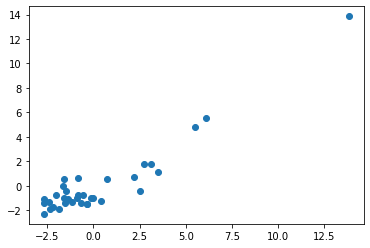

In [29]:
plot_4dm3_vs_4dm4('RC')

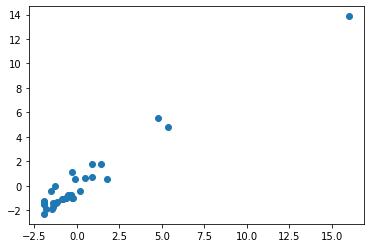

In [30]:
plot_4dm3_vs_4dm4('HB')

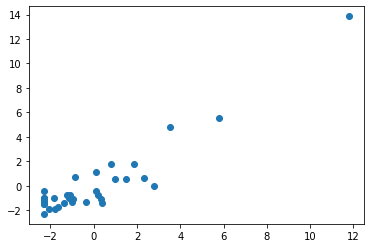

In [31]:
plot_4dm3_vs_4dm4('LN')

In [32]:
np.corrcoef(_4dm3_etis.values.T)

array([[1.        , 0.87942277, 0.76305664, 0.93471945],
       [0.87942277, 1.        , 0.89979523, 0.97796313],
       [0.76305664, 0.89979523, 1.        , 0.93021105],
       [0.93471945, 0.97796313, 0.93021105, 1.        ]])

In [33]:
model._linearETIRegression.coef_

array([0.        , 0.38920755, 0.52916245])

In [34]:
model._linearETIRegression.intercept_

0.37148016948980633